In [167]:
import polars as pl
from blyjections.clean import create_ids
from blyjections.yoy import get_consecutive_seasons

### Predict next year OPS from bat speed and hard hit percentage (2021-2025)
#### No bat speed data before ASG '23 so using maxEV as proxy which is good enough for now

(Doing this very very fast, so all errors are someone elses fault)

- Statcast data via pybaseball.statcast
- FanGraphs data via pybaseball.batting

In [168]:
batting = pl.read_parquet("data/batting_seasons.parquet")
batting = create_ids(batting)
batting = batting.select(["Season", "player_id", "AB", "OPS", "HardHit%", "maxEV"])
batting = batting.rename({"HardHit%": "HHPct"})
batting = batting.sort(["player_id", "Season"])
batting = get_consecutive_seasons(batting, player_col="player_id", season_col="Season")
batting = batting.with_columns( ## this aligns next year as the target
    pl.col("OPS")
    .shift(-1)
    .over("player_id")
    .alias("nxtOPS")
).drop_nulls("nxtOPS").drop("stretch_id")

batting.head()

Season,player_id,AB,OPS,HHPct,maxEV,nxtOPS
i64,str,i64,f64,f64,f64,f64
2016,"""10047-Wil Myers""",599,0.797,0.392,113.2,0.792
2018,"""10071-Jonathan Villar""",466,0.709,0.36,110.9,0.792
2019,"""10071-Jonathan Villar""",642,0.792,0.37,114.0,0.593
2020,"""10071-Jonathan Villar""",185,0.593,0.358,111.1,0.738
2015,"""10155-Mike Trout""",575,0.991,0.486,117.7,0.991


### Extremely naive model - treating each row as independent obs (this is not good)

In [169]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

## complete hold out to predict 2025 since it has to apply to the following year
batting_train = batting.filter(pl.col("Season") < 2024)
batting_test = batting.filter(pl.col("Season") == 2024) 

features = ["OPS", "HHPct", "maxEV"]
target = "nxtOPS"
weight = "AB"

X = batting_train[features]
y = batting_train[target]
w = batting_train[weight]

X_holdout = batting_test[features]
y_holdout = batting_test[target]


In [170]:

tscv = TimeSeriesSplit(n_splits=8)

r2_list = []
mae_list = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    weights_train = w[train_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train, sample_weight=weights_train)
    r2_list.append(r2_score(y_test, model.predict(X_test)))
    mae_list.append(mean_absolute_error(y_test, model.predict(X_test)))

print(f"CV Mean r2: {np.mean(r2_list):.4f}")
print(f"CV Mean MAE {np.mean(mae_list):.4f}")

mod = LinearRegression()
mod.fit(X, y, sample_weight=w)
print(f"Holdout r2: {r2_score(y_holdout, mod.predict(X_holdout)):.4f}")
print(f"Holdout MAE: {mean_absolute_error(y_holdout, mod.predict(X_holdout)):.4f}")


CV Mean r2: 0.1670
CV Mean MAE 0.0666
Holdout r2: 0.3140
Holdout MAE: 0.0557


In [171]:
y_pred = mod.predict(X_holdout)

batting_test = batting_test.with_columns(
    pl.Series("y_pred", y_pred),
    pl.Series("y_actual", y_holdout)
)

batting_test.head() ## y_holdout should equal nxtOPS

Season,player_id,AB,OPS,HHPct,maxEV,nxtOPS,y_pred,y_actual
i64,str,i64,f64,f64,f64,f64,f64,f64
2024,"""10324-Marcell Ozuna""",606,0.925,0.533,114.8,0.756,0.875869,0.756
2024,"""11493-Manny Machado""",593,0.797,0.488,115.6,0.795,0.817532,0.795
2024,"""11579-Bryce Harper""",550,0.898,0.477,113.8,0.844,0.853612,0.844
2024,"""11737-Nick Castellanos""",606,0.742,0.377,113.1,0.694,0.771698,0.694
2024,"""12533-Marcus Semien""",650,0.699,0.352,112.1,0.669,0.747807,0.669


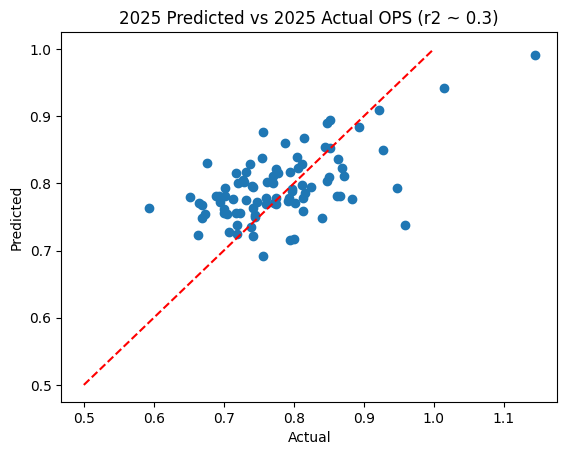

In [174]:
import matplotlib.pyplot as plt

plt.scatter(batting_test["y_actual"], batting_test["y_pred"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([0.5, 1], [0.5, 1], "r--")  # diagonal reference line
plt.title("2025 Predicted vs 2025 Actual OPS (r2 ~ 0.3)")
plt.show()